# Profile designer
This is the playground to design functions to fit the vertical structure of the East Atlantic's atmosphere in boreal summer. The data comes from previously extracted ERA5 profiles (from `Create-era5.ipynb`), and should be available in a local directory `./data/`. Two hypercube centers (south and north sub-domain) are then defined based on a set of chosen functions and free parameters, and stored in `./runs/`. The parameters for these runs are stored in a .csv; the input profiles for DALES in its usual format.

Additionally, a vertical grid, nudging profile and a backrad profile are defined, which can be used for all simulations in the eventual ensemble.

In [ ]:
import intake
import healpy as hp
import cmocean
import numpy as np
import xarray as xr
import pandas as pd
import os
from scipy.optimize import curve_fit

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt

import easygems.healpix as egh
import seaborn as sns

import thermo
import netCDF4 as nc

from profiles import *
import utils

In [2]:
Lv = 2.5e6
cp = 1004.
Rd = 287.05
grav = 9.81

data_path = './data'
data_path_fp = data_path+'/data_fp'

Text(0, 0.5, 'zf [m]')

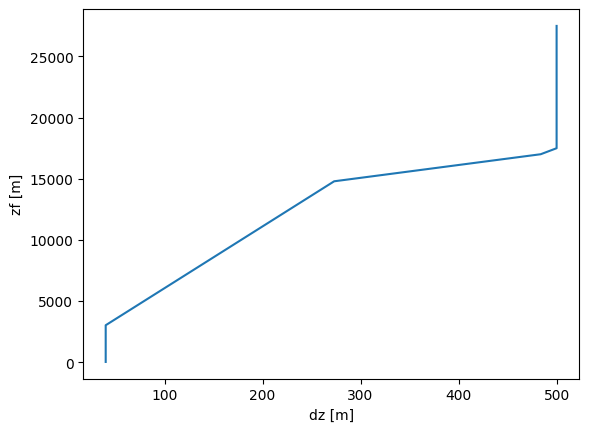

In [3]:
# Grid for DALES simulations, inspired by RCEMIP grid and EUREC4A grid

zlowmax = 3e3
dzlow   = 40
nztot   = 200
r0      = 1.02
zlow1max= 15e3 
r1      = 1.1
dzmax   = 500.

# Set the grid
zh, zf, = utils.make_grid(zlowmax, dzlow, nztot, r0, zlow1max, r1, dzmax=dzmax)

dz = np.diff(zh)
plt.plot(dz, zf)
plt.xlabel('dz [m]')
plt.ylabel('zf [m]')

# FIXME: The ERA5 levels do not reach TOA, only 20 km. Fix this for radiation, extrapolation of u,v,thl,qt.

In [4]:
# Nudging functions used in https://doi. org/10.1029/2023MS003796
def _nudge_atan(x, a=5, b=2, c=20, lev_max_change=5000, end=3600*6, test_plot=False):
            y = b * (np.pi/2+np.arctan(a* np.pi/2*(1-x/lev_max_change)))
            y = end + y**c
            # plot
            if test_plot:
                plt.figure(figsize=(6,9))
                plt.plot(y,x)
                plt.xlim([10e3,10e8])
                plt.ylim([0,5000])
                plt.xscale('log')
            return y

def create_nudging(zf, thl, qt, u, v, nudge_params):
    """
    Makes a nudging input file, based on 
    profiles to nudge towards of
    - zf
    - thl
    - qt
    - u
    - v
    nudge_params is a tuple that contains the input parameters to Alessandro's 
    arctangent nudging function.
    """
    
    zero = np.zeros(zf.shape)
    (a,b,c,z_max_change,tnudge_ft) = nudge_params
    
    # Nudging factor with height; 
    # is multiplied with nudging time (tnudgefac) from namelist;
    # here we set tnudgefac=1 -> Then this is the nudging time in seconds
    nudgefac = _nudge_atan(zf,a,b,c,z_max_change,tnudge_ft)
    
    out_profs = np.stack((zf,nudgefac,u,v,zero,thl,qt)).T
    
    return out_profs

## INITIAL ATTEMPT - NUDGING TOO STRONG
tnudge_ft = 6 # hours
lev_max_change = 6000 # m
nudge_params = (2,3,5,lev_max_change,tnudge_ft*3600) # ~18 hours near the surface

## SECOND ATTEMPT - WEAKER NUDGING
tnudge_ft = 6 # hours
lev_max_change = 15000 # m
nudge_params = (10,4.622,5,lev_max_change,tnudge_ft*3600) # ~7 days over FT

Free parameter values:
         thls    dthllt         hqt        u0      ujet
0  299.926558  0.496936  4059.26059  3.414611  2.896884
ps (rounded for all simulations): 101300
Actual thls - thl[0]: <xarray.DataArray 'theta_l' ()> Size: 8B
array(1.25)
Coordinates:
    level    float64 8B 1.011e+03
    expver   int32 4B 1
    zm       float64 8B 20.0
Free parameter values:
         thls    dthllt          hqt        u0     ujet
0  299.511256  2.354826  3598.007748  1.796379  6.52969
ps (rounded for all simulations): 101300
Actual thls - thl[0]: <xarray.DataArray 'theta_l' ()> Size: 8B
array(1.25)
Coordinates:
    level    float64 8B 1.011e+03
    expver   int32 4B 1
    zm       float64 8B 20.0


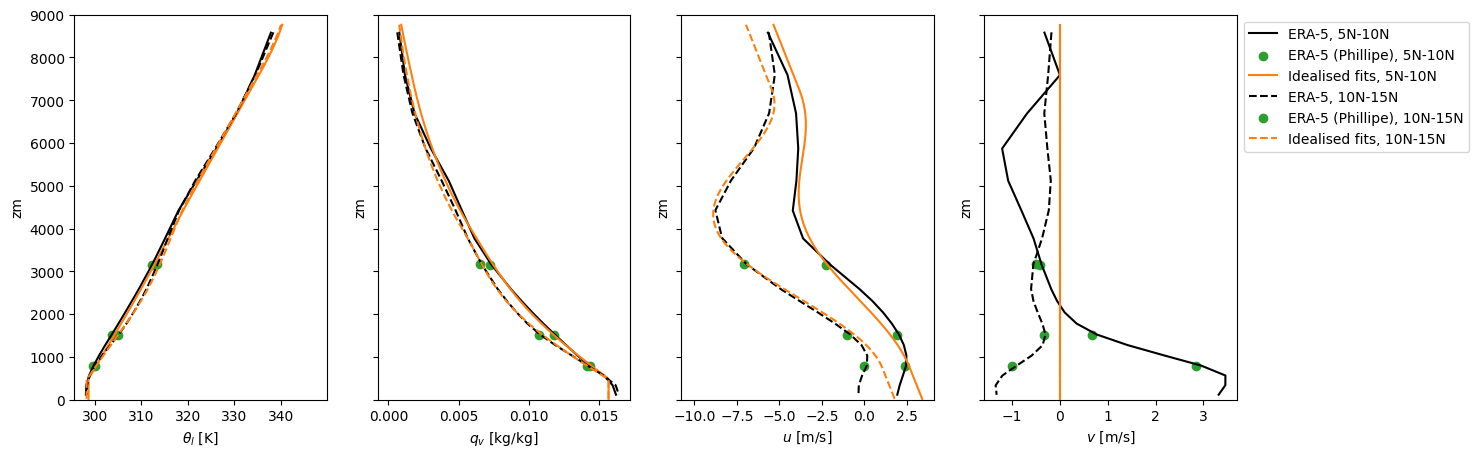

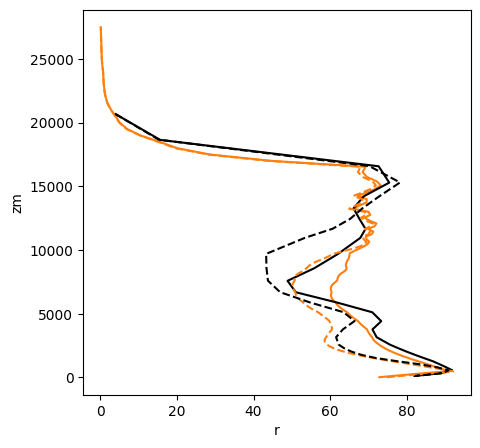

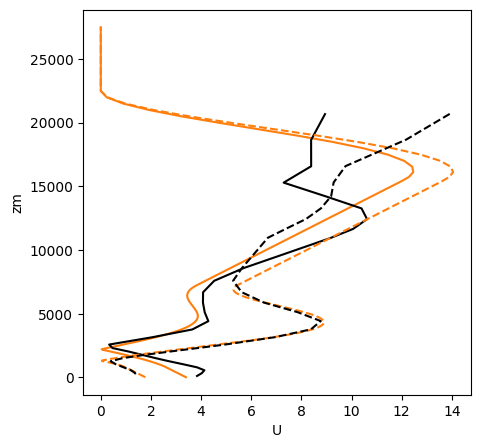

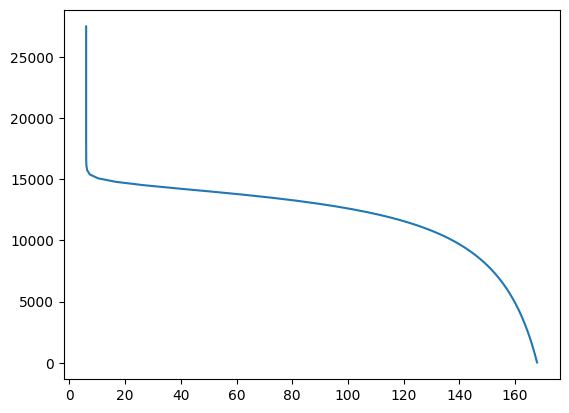

In [7]:
## Mean profiles
# era5 profiles, averaged over ~1200 summer days (Jul-Sep 2010-2023) and
# southern subdomain -  5N-10N, 23W-29W
# northern subdomain - 10N-15N, 23W-29W

# Surface pressure to use for all runs
ps_fixed = 101300 # Pa

# fitting height range
zfitmin = 0
zfitminu = 2e3
zfitmax = 8e3

# plotting range
zpltmax = 9e3

# domain names
doms = ['s', 'n']
lats = ['5N-10N','10N-15N']

# Plot settings
cs = ['black', 'C1', 'C2', 'C3']
lss = ['-','--']

# Where to store output files
out_dir = './runs/run_'

fig, axs = plt.subplots(ncols=4,figsize=(15,5),sharey=True)

fig_rh, ax_rh = plt.subplots(ncols=1,figsize=(5,5))

fig_u, ax_u = plt.subplots(ncols=1,figsize=(5,5))

# for i in range(1):
for i in range(len(doms)):
    # ERA5 from DKRZ (Create-era5.ipynb)
    era5_env_mn = xr.open_dataset(data_path+'/era5_env_'+doms[i]+'_mn.nc')

    # Manually retrieved ERA5 from Copernicus (used for higher levels, which do not exist in HERA5 from DKRZ)
    era5_allplev = xr.open_dataset(data_path+'/era5_month_allplev_'+doms[i]+'.nc').sel(expver=1)
    era5_allplev['zm'] = (era5_allplev['z']/grav).mean(['time','latitude','longitude'])
    era5_allplev = era5_allplev.set_coords(['zm']).swap_dims({'level':'zm'})
    era5_allplev['pres'] = era5_allplev['level'] * 100
    era5_allplev['theta_l']  = (1e5/era5_allplev['pres'])**(2/7)*(era5_allplev['t']) # FIXME Ignores clouds
        
    era5_allplev_mn = era5_allplev.mean(['time','latitude','longitude'])

    if i == 0:
        if doms[i] != 's':
            print('WARNING: Will not take the southern domain as reference, and will fail')
        era5_ref = era5_allplev_mn.copy(deep=True)
    
    # Surface pressure and surface theta_l
    thls = era5_env_mn['sst']*(1e5/era5_env_mn['sp'])**(2./7)

    # Use HERA5 (from DKRZ) for fits in lower troposphere
    era5_env_mn_fit = era5_env_mn.sel(zm=slice(zfitmax,zfitmin)).astype('float64')
    zfit = era5_env_mn['zm'].sel(zm=slice(zfitmax,zfitmin)).astype('float64')

    # Use a different range for u, to avoid fitting near-surface mixing which we want to model
    era5_env_mn_fit_u = era5_env_mn.sel(zm=slice(zfitmax,zfitminu)).astype('float64')
    zfit_u = era5_env_mn['zm'].sel(zm=slice(zfitmax,zfitminu)).astype('float64')

    # fit profiles
    [thlsf,dthllt], pcth = curve_fit(linml_sl,
                                    zfit, 
                                    era5_env_mn_fit['theta_l'], 
                                    p0=[300,0.1])

    # OLD with varying qt0, which hardly varies
    # [qt0,hqt], pcqt = curve_fit(exp,
    #                             zfit,
    #                             era5_env_mn_fit['q'],
    #                             p0=[0.016,1500])

    [hqt], pcqt = curve_fit(exp_h_lt,
                            zfit,
                            era5_env_mn_fit['q'],
                            p0=[1500])

    # OLD with varying shear, which gives better fits, but adds a difference between centers
    # [u0,dudz,ujet], pcu = curve_fit(linv_aej,
    #                                 zfit_u,
    #                                 era5_env_mn_fit_u['u'],
    #                                 p0=[-1, 0.00222,6])
    
    # With fixed shear, only jet
    [u0,ujet], pcu = curve_fit(linv_aej_fs,
                                zfit_u,
                                era5_env_mn_fit_u['u'],
                                p0=[-1, 6])

    ## OLD center included v
    [v0,dvdz], pcv = curve_fit(linv,
                               zfit_u,
                               era5_env_mn_fit_u['v'],
                               p0=[0,0])

    print('Free parameter values:')
    df_par = pd.DataFrame(data={'thls':thls.mean().data,
                                'dthllt':dthllt,
                                'hqt':hqt,
                                'u0':u0,
                                'ujet':ujet,
                                },
                         index=[0])
    print(df_par)
    out_dir_i = out_dir+str(i+1)
    df_par.to_csv(os.path.join(out_dir_i, 'parameters.csv'), index=False)
    
    # print('Parameters fixed for cube, but different between centers:')
    # print('Mean ps:', era5_env_mn['sp'].mean().data)
    print('ps (rounded for all simulations):', ps_fixed)

    # evaluate profiles
    thl = linml_sl(zf, thls.mean().data, dthllt)
    qt = exp_h_lt(zf, hqt)
    u = linv_aej_fs(zf, u0, ujet)
    v = linv(zf, v0, dvdz)
    
    # Set v to zero
    v = v*0.

    # relax them back to the reference state using ERA5, which is
    # - the southern domain mean upper troposphere for q/theta_l
    # - zero for u and v
    href_relax=9e3 # Relax to same profile in the upper troposphere, which we do not control
    hsca_relax=3e3
    href_relax_u=19e3 # Above the tropopause, relax to zero
    hsca_relax_u=7e3
    qt = relax(zf, qt, era5_ref['q'], href_relax, hsca_relax)
    thl = relax(zf, thl, era5_ref['theta_l'], href_relax, hsca_relax)
    u = relax(zf, u, era5_ref['u']*0, href_relax_u, hsca_relax_u)
    v = relax(zf, v, era5_ref['v']*0, href_relax_u, hsca_relax_u)

    # print the cu you would need to offset the u in the shallow convection-topped layer
        
    # check that thls>thl[0]
    dthls0 = thls.mean().data-thl[0]
    print('Actual thls - thl[0]:', dthls0.values)

    ## Compare with the mean profiles from Phillipe

    ds_t_pp = xr.open_dataset(data_path_fp+'/t_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_q_pp = xr.open_dataset(data_path_fp+'/q_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_u_pp = xr.open_dataset(data_path_fp+'/u_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_v_pp = xr.open_dataset(data_path_fp+'/v_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')
    ds_d_pp = xr.open_dataset(data_path_fp+'/d_vertical_profile_clim_'+lats[i]+'_23W-29W.nc')

    ds_pp = xr.merge([ds_t_pp, ds_q_pp, ds_u_pp, ds_v_pp, ds_d_pp])

    ## Move these data to the heights of the finer dataset, and convert t to potential t
    ds_pp['theta_l'] = ds_pp['t']*(1e5/ds_pp['lev']/100)**(2./7)
    ds_pp['z'] = era5_env_mn['theta_l'].swap_dims({'zm':'level'}).sel(level=ds_pp['lev'])
    ds_pp = ds_pp.swap_dims({'lev':'z'})
    
    ## Check RH
    # Interpolate pressure to model grid for RH calculations
    pres = (era5_allplev_mn['level']*100)
    pres0 = era5_env_mn['sp']
    pres_np = np.flip(np.append(pres.to_numpy(),pres0.to_numpy()))
    zm_np = np.flip(np.append(pres['zm'].to_numpy(), 0.))
    pres = xr.DataArray(data=pres_np, coords={'zm':zm_np})
    pres_zf = pres.interp(zm=zf,kwargs={"fill_value": "extrapolate"})
    rh = rhProf(thl.to_numpy(), qt.to_numpy(), pres_zf.to_numpy())

    ## Check momentum
    # mean-flow total momentum (not equal mean of total momentum)
    U = np.sqrt(u**2 + v**2)
    era5_env_mn['U'] = np.sqrt(era5_env_mn['u']**2 + era5_env_mn['v']**2)
    
    ## Plot everything up to zpltmax (so this plot may truncate the simulation grid if zpltmax < zf[-1])
    izmax = np.where(zf<zpltmax)[0][-1]
    zfplt = zf[:izmax]
    era5_env_mn_plt = era5_env_mn.sel(zm=slice(np.max(zfplt),np.min(zfplt)))

    era5_env_mn_plt['theta_l'].plot(y='zm', ax=axs[0], color=cs[0], linestyle=lss[i])
    axs[0].scatter(ds_pp['theta_l'], ds_pp['zm'], c=cs[2])
    axs[0].plot(thl[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[0].set_xlabel(r'$\theta_l$ [K]')

    era5_env_mn_plt['q'].plot(y='zm', ax=axs[1], color=cs[0], linestyle=lss[i])
    axs[1].scatter(ds_pp['q'], ds_pp['zm'], c=cs[2])
    axs[1].plot(qt[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[1].set_xlabel(r'$q_v$ [kg/kg]')

    era5_env_mn_plt['u'].plot(y='zm', ax=axs[2], color=cs[0], linestyle=lss[i])
    axs[2].scatter(ds_pp['u'], ds_pp['zm'], c=cs[2])
    axs[2].plot(u[:izmax], zfplt, color=cs[1], linestyle=lss[i])
    axs[2].set_xlabel(r'$u$ [m/s]')

    era5_env_mn_plt['v'].plot(y='zm', ax=axs[3], color=cs[0], linestyle=lss[i], label='ERA-5, '+lats[i])
    axs[3].scatter(ds_pp['v'], ds_pp['zm'], c=cs[2], label='ERA-5 (Phillipe), '+lats[i])
    axs[3].plot(v[:izmax], zfplt, color=cs[1], linestyle=lss[i], label='Idealised fits, '+lats[i])
    axs[3].set_xlabel(r'$v$ [m/s]')

    axs[3].legend(bbox_to_anchor=(1,1), loc='best')
    
    # Plot RH
    ax_rh.plot(rh, zf, linestyle=lss[i], color=cs[1])
    era5_env_mn['r'].plot(y='zm', ax=ax_rh, linestyle=lss[i], color=cs[0])

    # Plot U
    ax_u.plot(U, zf, linestyle=lss[i], color=cs[1])
    era5_env_mn['U'].plot(y='zm', ax=ax_u, linestyle=lss[i], color=cs[0])
    
    ## Write to DALES input format
    experiment='001'
    
    # prof.inp
    tke = 1 - zf/3000; tke[zf>=3000] = 0.
    prof = np.stack((zf,thl.to_numpy(),qt.to_numpy(),u.to_numpy(),v.to_numpy(),tke)).T
    profile_out = os.path.join(out_dir_i, 'prof.inp.'+experiment)
    np.savetxt(profile_out, prof, fmt='%12.6g',
               header='\n    height         thl          qt            u            v          TKE')

    # lscale.inp
    # no large-scale forcing other than nudging
    zero = np.zeros(zf.shape)

    lscale = np.stack((zf,u,v,zero,zero,zero,zero,zero)).T
    lscale_out = os.path.join(out_dir_i, 'lscale.inp.'+experiment)
    np.savetxt(lscale_out, lscale, fmt='%12.6g',
               header='\n    height           ug           vg         wfls      dqtdxls      dqtdyls      dqtdtls      dthlrad')

    # scalar.inp
    scalar = np.stack((zf,zero,zero)).T
    scalar_out = os.path.join(out_dir_i, 'scalar.inp.'+experiment)
    np.savetxt(scalar_out, scalar, fmt='%12.6g',
               header='#\nheight  nr  qr', comments='')
    
    # nudge.inp
    nudge_profs = create_nudging(zf, thl, qt, u, v, nudge_params)
    
    nudge_out = os.path.join(out_dir_i, 'nudge.inp.'+experiment)
    f = open(nudge_out, 'w')
    f.close()
    
    # Append two time instances - one at start, one after end of simulation
    with open(nudge_out, 'ab') as f:
        np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
                   header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)    \n# 0.00000000E+00')
        np.savetxt(f, nudge_profs, fmt='%+10.10e', comments='',
                   header='\n      z (m)          factor (-)         u (m s-1)         v (m s-1)         w (m s-1)          thl (K)        qt (kg kg-1)    \n# 1.00000000E+07')

axs[0].set_ylim(0,zpltmax)
# axs[0].set_xlim(297,315)
plt.savefig(data_path+'/figures/prof-test.pdf',bbox_inches='tight')

plt.figure()
plt.plot(nudge_profs[:,1]/3600,zf)

In [27]:
# backrad.inp.001.nc
# Since upper troposphere in all simulations is from the same ERA5 profile, we can use the same profile to extrapolate
# immediately above the TOM, without creating large spurious gradients, in all Botany simulations.

# Use from RCEMIP:
# - that the TOA is at 50 Pa
# - the function for o3(pres)
# - the humidity

# Where to store output files
out_dir_rad = './runs'

backrad_rce = xr.open_dataset(data_path+'/backrad_rce.nc')
brl = era5_ref.isel(zm=slice(None, None, -1)).swap_dims({'zm':'level'})
brl['level'] = brl['level']*100

## pressure (from ERA5, extrapolated to 50 Pa)
pres_br = np.hstack([brl['level'].to_numpy(), [50.]])

## temperature
# Extrapolate above ERA5 to 50 Pa level using the international standard atmosphere (https://www.digitaldutch.com/atmoscalc/)
# offset to fit at the highest ERA5 level
Tf = brl['t'].isel(level=-1)
dT_ISA = Tf - 270.650 # ISA offset
T50 = 256.488 # Offset ISA T at 50 Pa

T_br = np.hstack([brl['t'].to_numpy(), [T50]])

## q
# Extrapolate by assuming it stays constant at the final ERA5 value
q_br = np.hstack([brl['q'], [brl['q'][-1]]])

## o3
# Reconstruct RCEMIP profile (from Wing et al., 2018 - https://doi.org/10.5194/gmd-11-793-2018)
def o3_wing(p, g1, g2, g3):
    p = p/100 # Pa -> hPa
    return g1*p**g2*np.exp(-p/g3)/1e6

g1 = 3.6478
g2 = 0.83209
g3 = 11.3513
o3_rcemip = o3_wing(backrad_rce['lev'], g1, g2, g3)

# Use the same function to fit our o3 to TOA
[g1b, g2b, g3b], pco3 = curve_fit(o3_wing, brl['level'], brl['o3'], p0=[g1*1.6,g2,g3])
o3_br = o3_wing(pres_br, g1b, g2b, g3b)

# Create backrad
backrad_out = os.path.join(out_dir_rad,'backrad.inp.'+experiment+'.nc')

nc_file = nc.Dataset(backrad_out, 'w')
nc_file.title = 'Background radiation input for deep-botany simulations, from ERA5'

dims = nc_file.createDimension('lev', pres_br.size)

p_var = nc_file.createVariable('lev', 'f4', ('lev'))
T_var = nc_file.createVariable('T',   'f4', ('lev'))
q_var = nc_file.createVariable('q',   'f4', ('lev'))
o_var = nc_file.createVariable('o3',  'f4', ('lev'))

p_var.units = 'Pa'
T_var.units = 'K'
q_var.units = 'kg/kg'
o_var.units = '-'

p_var[:] = pres_br
T_var[:] = T_br
q_var[:] = q_br
o_var[:] = o3_br

nc_file.close()

## Plot
# fig=plt.figure(); ax = plt.gca()
# backrad_rce['T'].plot(y='lev',ax=ax)
# brl['t'].plot(y='level',ax=ax)
# plt.plot(T_br, pres_br)
# ax.set_yscale('log')
# plt.plot()

# fig=plt.figure(); ax = plt.gca()
# backrad_rce['q'].plot(y='lev',ax=ax)
# brl['q'].plot(y='level',ax=ax)
# plt.plot(q_br, pres_br)
# ax.set_yscale('log')
# ax.set_xscale('log')
# plt.plot()

# fig=plt.figure(); ax = plt.gca()
# backrad_rce['o3'].plot(y='lev',ax=ax)
# brl['o3'].plot(y='level',ax=ax)
# o3_rcemip.plot(y='lev',ax=ax)
# plt.plot(o3_br, pres_br)
# ax.set_yscale('log')
# plt.plot()